#  Vision-based End-to-End Driving Tutorial

- Website: https://waymo.com/open
- GitHub: https://github.com/waymo-research/waymo-open-dataset
- Challenge: https://waymo.com/open/challenges/2025/e2e-driving/

This tutorial demonstrates how to load, visualize and submit end-to-end driving data. Visit the [Waymo Open Dataset Website](https://waymo.com/open) to download the full dataset.

To use, open this notebook in [Colab](https://colab.research.google.com).

Uncheck the box "Reset all runtimes before running" if you run this colab directly from the remote kernel. Alternatively, you can make a copy before trying to run it by following "File > Save copy in Drive ...".



## Package installation 🛠️

In [3]:
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import math
import numpy as np
import cv2
from waymo_open_dataset import dataset_pb2 as open_dataset
from waymo_open_dataset.wdl_limited.camera.ops import py_camera_model_ops

from waymo_open_dataset.protos import end_to_end_driving_data_pb2 as wod_e2ed_pb2
from waymo_open_dataset.protos import end_to_end_driving_submission_pb2 as wod_e2ed_submission_pb2

2025-04-08 18:58:03.704781: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-08 18:58:03.706325: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 18:58:03.734907: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-08 18:58:03.735443: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-08 18:58:05.078182: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Loading the data

Visit the [Waymo Open Dataset Website](https://waymo.com/open/) to download the
full dataset.

In [4]:
# Replace this path with your own tfrecords.
# This tutorial is based on using data in the E2E Driving proto format directly,
# so choose the correct dataset version.
DATASET_FOLDER = 'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0'

TRAIN_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')
VALIDATION_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')
TEST_FILES = os.path.join(DATASET_FOLDER, '*.tfrecord-*')


Initialize dataset object.

In [5]:
os.environ['CURL_CA_BUNDLE'] = '/home/aaylen/Documents/Waymo-Challenge/cacert.pem'
os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = '/home/aaylen/Documents/Waymo-Challenge/token.json'

In [6]:
filenames = tf.io.matching_files(TRAIN_FILES)
dataset = tf.data.TFRecordDataset(filenames, compression_type='')
dataset_iter = dataset.as_numpy_iterator()

2025-04-08 18:58:14.926300: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-04-08 18:58:14.926676: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2025-04-08 18:58:16.383241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

In [7]:
print(filenames)

tf.Tensor(
[b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00000-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00001-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00002-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00003-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00004-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00005-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00006-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00007-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00008-of-00315'
 b'gs://waymo_open_dataset_end_to_end_camera_v_1_0_0/training_202503292338.tfrecord-00009

Retrieve one example.

In [23]:
bytes_example = next(dataset_iter)
data = wod_e2ed_pb2.E2EDFrame()
data.ParseFromString(bytes_example)

1509497

## Visualizing the future trajectories on image
In this tutorial, we will visualize a single camera image and project the trajectory on the three front cameras.

In [25]:
def return_front3_cameras(data: wod_e2ed_pb2.E2EDFrame):
  """Return the front_left, front, and front_right cameras as a list of images"""
  image_list = []
  calibration_list = []
  # CameraName Enum reference:
  # https://github.com/waymo-research/waymo-open-dataset/blob/5f8a1cd42491210e7de629b6f8fc09b65e0cbe99/src/waymo_open_dataset/dataset.proto#L50
  order = [2, 1, 3]
  for camera_name in order:
    for index, image_content in enumerate(data.frame.images):
      if image_content.name == camera_name:
        # Decode the raw image string and convert to numpy type.
        calibration = data.frame.context.camera_calibrations[index]
        image = tf.io.decode_image(image_content.image).numpy()
        image_list.append(image)
        calibration_list.append(calibration)
        break

  return image_list, calibration_list

Visualize the front 3 cameras

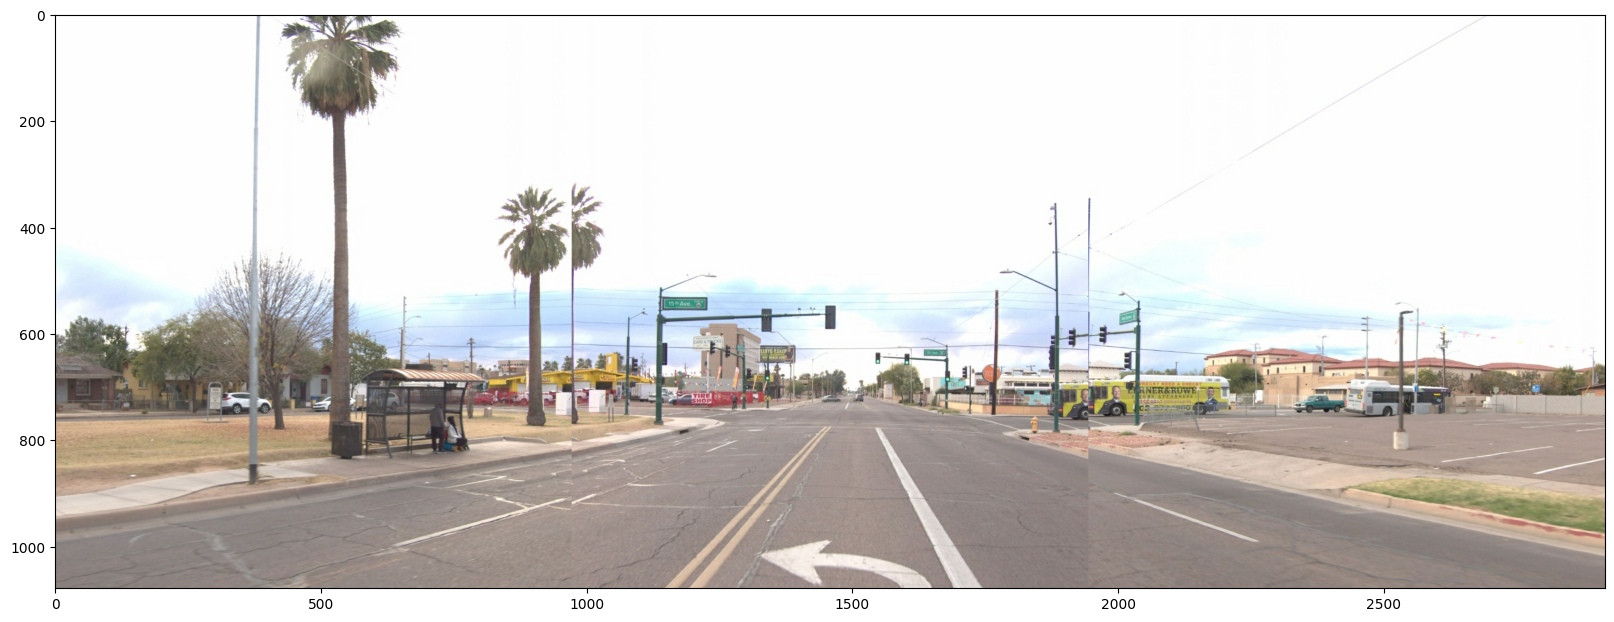

In [27]:
front3_camera_image_list, front3_camera_calibration_list = return_front3_cameras(data)
concatenated_image = np.concatenate(front3_camera_image_list, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

In [28]:
def project_vehicle_to_image(vehicle_pose, calibration, points):
  """Projects from vehicle coordinate system to image with global shutter.

  Arguments:
    vehicle_pose: Vehicle pose transform from vehicle into world coordinate
      system.
    calibration: Camera calibration details (including intrinsics/extrinsics).
    points: Points to project of shape [N, 3] in vehicle coordinate system.

  Returns:
    Array of shape [N, 3], with the latter dimension composed of (u, v, ok).
  """
  # Transform points from vehicle to world coordinate system (can be
  # vectorized).
  pose_matrix = np.array(vehicle_pose.transform).reshape(4, 4)
  world_points = np.zeros_like(points)
  for i, point in enumerate(points):
    cx, cy, cz, _ = np.matmul(pose_matrix, [*point, 1])
    world_points[i] = (cx, cy, cz)

  # Populate camera image metadata. Velocity and latency stats are filled with
  # zeroes.
  extrinsic = tf.reshape(
      tf.constant(list(calibration.extrinsic.transform), dtype=tf.float32),
      [4, 4])
  intrinsic = tf.constant(list(calibration.intrinsic), dtype=tf.float32)
  metadata = tf.constant([
      calibration.width,
      calibration.height,
      open_dataset.CameraCalibration.GLOBAL_SHUTTER,
  ],
                         dtype=tf.int32)
  camera_image_metadata = list(vehicle_pose.transform) + [0.0] * 10

  # Perform projection and return projected image coordinates (u, v, ok).
  return py_camera_model_ops.world_to_image(extrinsic, intrinsic, metadata,
                                            camera_image_metadata,
                                            world_points).numpy()

In [29]:
def draw_points_on_image(image, points, size):
  """Draws points on an image.

  Args:
    image: The image to draw on.
    points: A numpy array of shape (N, 2) representing the points to draw.
  """
  for point in points:
    cv2.circle(image, (int(point[0]), int(point[1])), size, (255, 0, 0), -1)
  return image

Extract the ego vehicle's future trajectory and reshape to (N, 3) matrix.

In [30]:
future_waypoints_matrix = np.stack([data.future_states.pos_x, data.future_states.pos_y, data.future_states.pos_z], axis=1)

The pose is always an identity matrix as we already convert world coordinates to vehicle coordinates.

In [31]:
vehicle_pose = data.frame.images[0].pose

We convert the ego vehicle's future waypoints to camera space and draw on camera.

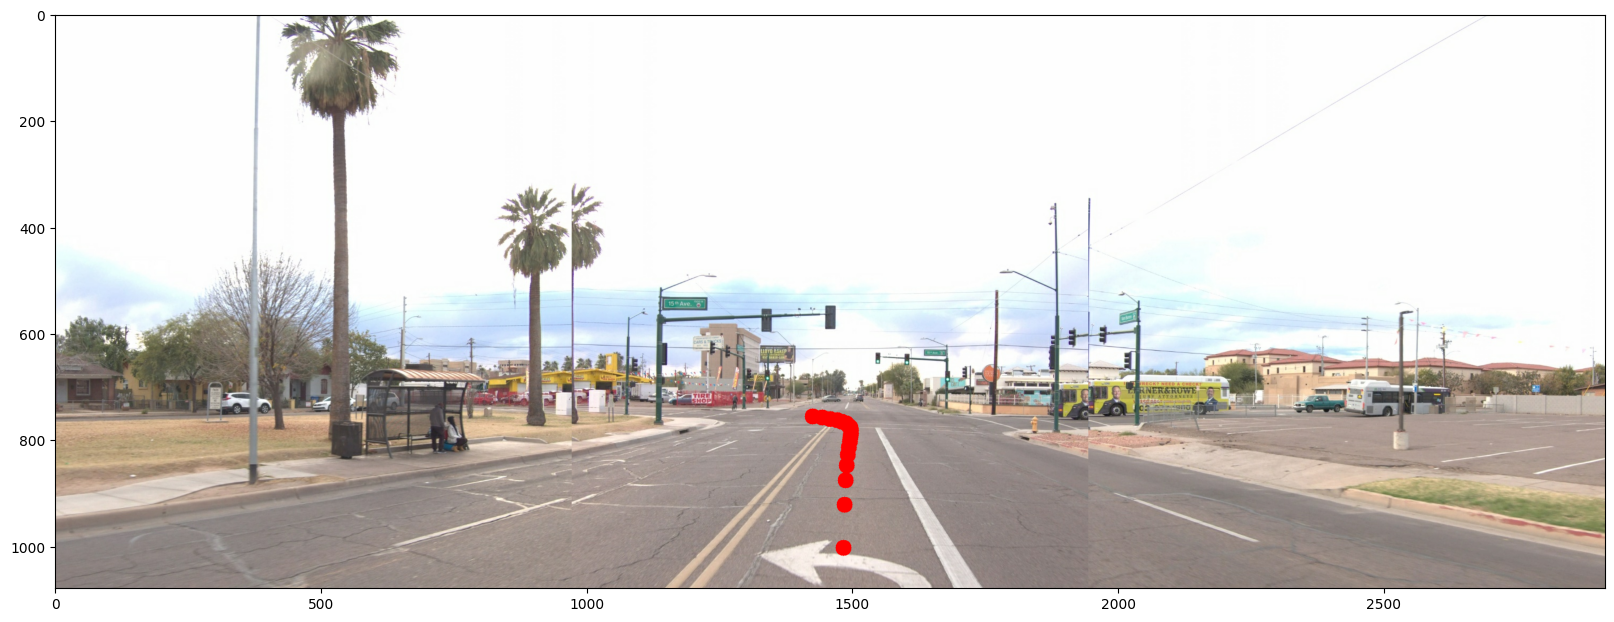

In [32]:
images_with_drawn_points = []
for i in range(len(front3_camera_calibration_list)):
  waypoints_camera_space = project_vehicle_to_image(vehicle_pose, front3_camera_calibration_list[i], future_waypoints_matrix)
  images_with_drawn_points.append(draw_points_on_image(front3_camera_image_list[i], waypoints_camera_space, size=15))
concatenated_image = np.concatenate(images_with_drawn_points, axis=1)
plt.figure(figsize=(20, 20))
plt.imshow(concatenated_image)

## Submission generation

The `wod_e2ed_submission_pb2` defines the proto format of the submission.

The participants are required to produce **a single trajectory** starting after the last provided frame. The trajectory should follow  `TrajectoryPrediction` format and has a length of 5 seconds and a frequency of 4 HZ. Then the participants should add the corresponding frame name to form `FrameTrajectoryPredictions`.  The evaluation server will compute detailed metrics and add them to the leaderboard.

This section will demonstrate how submission file is created

In [ ]:
# Assume we have a predicted stopping trajectory.
predicted_trajectory = wod_e2ed_submission_pb2.TrajectoryPrediction(pos_x=np.zeros(20, dtype=np.float32),
                                                                    pos_y=np.zeros(20, dtype=np.float32))
frame_name = data.frame.context.name
frame_trajectory = wod_e2ed_submission_pb2.FrameTrajectoryPredictions(frame_name=frame_name, trajectory=predicted_trajectory)
# The final prediction should be a list of FrameTrajectoryPredictions.
predictions = [frame_trajectory]

In [ ]:
# Pack for submission.
num_submission_shards = 1  # Please modify accordingly.
submission_file_base = '/tmp/MySubmission'  # Please modify accordingly.
if not os.path.exists(submission_file_base):
  os.makedirs(submission_file_base)
sub_file_names = [
    os.path.join(submission_file_base, part)
    for part in [f'part{i}' for i in range(num_submission_shards)]
]
# As the submission file may be large, we shard them into different chunks.
submissions = []
num_predictions_per_shard =  math.ceil(len(predictions) / num_submission_shards)
for i in range(num_submission_shards):
  start = i * num_predictions_per_shard
  end = (i + 1) * num_predictions_per_shard
  submissions.append(
      wod_e2ed_submission_pb2.E2EDChallengeSubmission(
          predictions=predictions[start:end]))

In [ ]:
for i, shard in enumerate(submissions):
  shard.submission_type  =  wod_e2ed_submission_pb2.E2EDChallengeSubmission.SubmissionType.E2ED_SUBMISSION
  shard.authors[:] = ['A', 'B']  # Please modify accordingly.
  shard.affiliation = 'Affiliation'  # Please modify accordingly.
  shard.account_name = 'acc@domain.com'  # Please modify accordingly.
  shard.unique_method_name = 'YourMethodName'  # Please modify accordingly.
  shard.method_link = 'method_link'  # Please modify accordingly.
  shard.description = ''  # Please modify accordingly.
  shard.uses_public_model_pretraining = True # Please modify accordingly.
  shard.public_model_names.extend(['Model_name']) # Please modify accordingly.
  shard.num_model_parameters = "200k" # Please modify accordingly.
  with tf.io.gfile.GFile(sub_file_names[i], 'wb') as fp:
    fp.write(shard.SerializeToString())

In [ ]:
print(submissions[0])

## Package submission
```
cd /tmp
tar cvf MySubmission.tar MySubmission
gzip MySubmission.tar
```
Then you can upload `/tmp/MySubmission.tar.gz` to the challenge website.


## Evaluation
Once the predictions are submitted, our eval server will run the [rater feedback metric](https://waymo.com/intl/en_us/open/challenges/2025/e2e-driving/) to compute the rater feedback scores and update the leaderboard. As the rater feedback metric code won't be released, here we provide a simple ADE Metric implementation to help participants self-evaluate.

In [ ]:
def average_distance_per_step(
    predictions , observed_traj, mask
) :
  """Compute L2 distance between proposed trajectories and ground truth.

  Args:
    predictions: A numpy array representing model predictions of size: [# proposals,
      # time steps, spatial features].
    observed_traj: A tensor representing the observed trajectory in the logs of
      size [# time steps, spatial features]
    mask: A boolean tensor representing the time steps that have valid
      observations of size [# time steps].

  Returns:
    A tensor of size [# proposals]
  """
  dist_per_step = np.linalg.norm(
      predictions - observed_traj[np.newaxis], axis=-1
  )
  dist_per_traj = (dist_per_step * mask[np.newaxis]).sum(axis=-1)
  valid_steps = np.maximum(mask.sum(axis=-1, keepdims=True), 1.0)
  avg_distance = dist_per_traj / valid_steps
  return avg_distance


Convert both gt and predictions to a format of dictionary for convenience.

In [ ]:
# {frame_name: trajectory}
gt_dict = {}
prediction_dict = {}
gt_dict[data.frame.context.name] =  np.stack([data.future_states.pos_x, data.future_states.pos_y], axis=1)
for submission in submissions:
  for prediction in submission.predictions:
    prediction_dict[prediction.frame_name] = np.stack([prediction.trajectory.pos_x, prediction.trajectory.pos_y], axis=1)

In [ ]:
# Compute ADEs. Our ade calculation is generalized to multiple proposal and masking enabled.
ade_list = []
for frame_name in gt_dict:
  if frame_name not in prediction_dict:
    raise ValueError(f'No prediction for {frame_name}')
  gt_traj = gt_dict[frame_name]
  pred_traj = prediction_dict[frame_name]
  mask = np.ones(gt_traj.shape[0], dtype=np.bool_)
  ade_list.append(average_distance_per_step(pred_traj[None], gt_traj, mask)[0])


In [ ]:
print(f'ADE: {np.mean(ade_list)}')